## Проект: вариант 1
Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения:

1. В первую очередь, его интересует показатель retention. Напишите функцию для его подсчета.
2. Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных определите, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.
3. Предложите метрики для оценки результатов последнего прошедшего тематического события в игре.

In [13]:
# импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import scipy.stats as ss
from tqdm.auto import tqdm
from datetime import datetime
import requests
from urllib.parse import urlencode 
import json
from tqdm.auto import tqdm
from scipy.stats import norm, mannwhitneyu

%matplotlib inline

### Задание 1
Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока). Данные лежат в папке shared.

In [14]:
# импорт данных из папки shared
df_reg = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-smirnov-24/shared/problem1-reg_data.csv', sep=';')
df_auth = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-smirnov-24/shared/problem1-auth_data.csv', sep=';')

In [15]:
# структура данных
df_reg.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [16]:
df_auth.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


###### Базовая предобработка данных

In [17]:
# количество сторок
display(df_reg.shape[0], df_auth.shape[0])

1000000

9601013

In [18]:
# проверка на отсутствие пропущенных значений
display(df_reg.isna().sum(),df_auth.isna().sum())

reg_ts    0
uid       0
dtype: int64

auth_ts    0
uid        0
dtype: int64

In [19]:
# проверка типа данных
display(df_reg.dtypes, df_auth.dtypes)

reg_ts    int64
uid       int64
dtype: object

auth_ts    int64
uid        int64
dtype: object

In [20]:
# проверка количества уникальных пользователей в каждом из df
display(df_reg['uid'].nunique(), df_auth['uid'].nunique())

1000000

1000000

In [21]:
# дата первой и последней регистрации
display(datetime.utcfromtimestamp(df_reg.reg_ts.min()).strftime('%Y-%m-%d'),datetime.utcfromtimestamp(df_reg.reg_ts.max()).strftime('%Y-%m-%d'))

'1998-11-18'

'2020-09-23'

In [22]:
# дата первой и последней авторизации
display(datetime.utcfromtimestamp(df_auth.auth_ts.min()).strftime('%Y-%m-%d'),datetime.utcfromtimestamp(df_auth.auth_ts.max()).strftime('%Y-%m-%d'))

'1998-11-18'

'2020-09-23'

##### Функция по подсчёту retention игроков
В качестве аргументов функции будут выступать:
* df_reg - датафрейм с данными регистрации пользователей
* df_auth - датафрейм с данными авторизации пользователей
* start_date - начальная дата сэмпла данных (min значение '1998-11-18', max значение '2020-09-23')
* finish_date - конечная дата сэмпла данных (min значение '1998-11-18', max значение '2020-09-23')
* n_day - аргумент для задания n-ного дня ретеншена (int)

In [23]:
def retention_n_day(df_reg, df_auth, start_date, finish_date, n_day):
    start_date = pd.to_datetime(start_date).strftime('%Y-%m-%d')
    finish_date = pd.to_datetime(finish_date).strftime('%Y-%m-%d')
    
    # объединение df регистрации и авторизации по id пользователя
    df_general = df_auth.merge(df_reg, on='uid')
    
    # перевод в корректное отображение дат из формата ts
    df_general['reg_time'] = pd.to_datetime(df_general.reg_ts, unit='s').dt.round('d')
    df_general['auth_time'] = pd.to_datetime(df_general.auth_ts, unit='s').dt.round('d')
    
    # удаление столбцов даты формата ts
    df_general = df_general.drop(['reg_ts', 'auth_ts'], axis=1)
    
    # создание столбца с количеством дней прошедших с начала регистрации для каждого случая авторизации
    df_general['days_since_reg'] = (df_general['auth_time'] - df_general['reg_time']).dt.days
    
    # сэмплирование данных по интересующему нас пробежутку времени
    df_sample = df_general[(df_general['reg_time'] >= start_date) & (df_general['reg_time'] <= finish_date) & (df_general['days_since_reg'] <= n_day)]
    
    # подсчёт процента удержания
    df_cohort = ((df_sample.groupby(['reg_time', 'days_since_reg']).agg({'uid':'nunique'}))/df_sample.groupby('reg_time').agg({'uid':'nunique'})) \
                .reset_index().rename(columns={'uid':'percent'})
    
    # retention таблица, для формирования heatmap визуализации   
    retention = df_cohort.pivot(index='reg_time', columns='days_since_reg', values='percent')
    retention = retention.divide(retention.iloc[:,0],axis=0).fillna(0).round(3)
    
    # настройка визуализации данных
    plt.figure(figsize=(20, 15))
    ax = sns.heatmap(retention, cmap="coolwarm", annot=True, fmt=".1%", vmax=0.1)
    ticklabels = [retention.index[int(tick)].strftime('%Y-%m-%d') for tick in ax.get_yticks()]
    ax.set_yticklabels(ticklabels)
    ax.set_title('Retention {} days from {} to {}'.format(n_day, start_date, finish_date ), fontsize=30)
    ax.set(xlabel="Days since registration", ylabel="Registration Day")
    sns.despine()
    
    
    return retention

days_since_reg,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
reg_time,,,,,,,,,,,,,,,,
2018-07-01,1.0,0.028,0.039,0.049,0.077,0.060,0.086,0.067,0.049,0.074,0.053,0.046,0.081,0.042,0.035,0.058
2018-07-02,1.0,0.009,0.040,0.035,0.084,0.037,0.079,0.047,0.049,0.035,0.079,0.053,0.067,0.047,0.021,0.053
2018-07-03,1.0,0.019,0.039,0.051,0.046,0.042,0.058,0.058,0.030,0.060,0.044,0.053,0.032,0.049,0.049,0.049
2018-07-04,1.0,0.014,0.046,0.062,0.053,0.069,0.056,0.053,0.044,0.056,0.072,0.049,0.032,0.049,0.058,0.058
2018-07-05,1.0,0.009,0.028,0.048,0.051,0.058,0.065,0.065,0.030,0.046,0.065,0.051,0.053,0.046,0.046,0.046
2018-07-06,1.0,0.021,0.037,0.035,0.074,0.048,0.069,0.053,0.062,0.053,0.065,0.055,0.046,0.053,0.046,0.053
2018-07-07,1.0,0.016,0.037,0.060,0.037,0.053,0.076,0.048,0.046,0.044,0.053,0.046,0.046,0.046,0.030,0.041


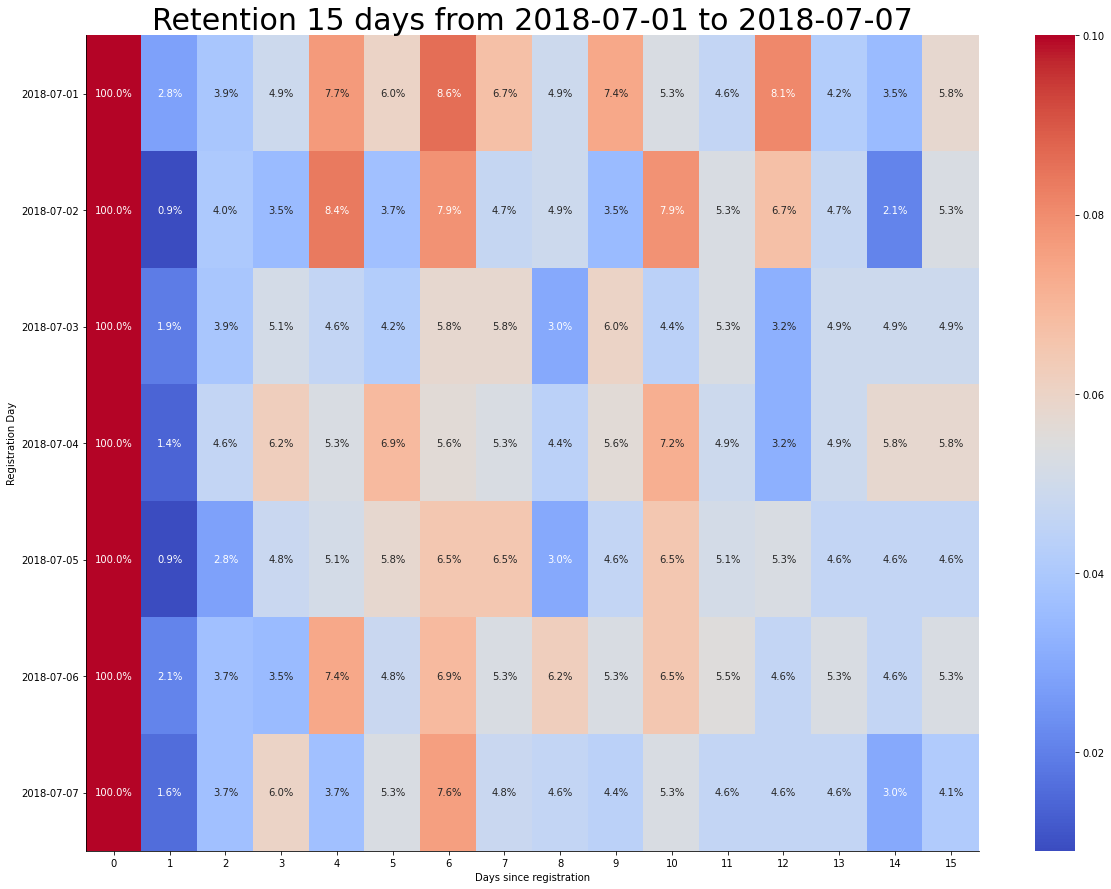

In [24]:
start_date = '2018-07-01'
finish_date = '2018-07-07'
n_day = 15
retention_n_day(df_reg, df_auth, start_date, finish_date, n_day)

##### Функция по подсчёту динамики retention
В качестве аргументов функции будут выступать:
* df_reg - датафрейм с данными регистрации пользователей
* df_auth - датафрейм с данными авторизации пользователей
* start_date2 - начальная дата сэмпла данных (min значение '1998-11-18', max значение '2020-09-23')
* finish_date2 - конечная дата сэмпла данных (min значение '1998-11-18', max значение '2020-09-23')

In [25]:
def dynamic_retention(df_reg, df_auth, start_date2, finish_date2):
    start_date2 = pd.to_datetime(start_date2).strftime('%Y-%m-%d')
    finish_date2 = pd.to_datetime(finish_date2).strftime('%Y-%m-%d')
    
    # объединение df регистрации и авторизации по id пользователя
    df_general2 = df_auth.merge(df_reg, on='uid')
    
    # перевод в корректное отображение дат из формата ts
    df_general2['reg_time'] = pd.to_datetime(df_general2.reg_ts, unit='s').dt.round('d')
    df_general2['auth_time'] = pd.to_datetime(df_general2.auth_ts, unit='s').dt.round('d')
    
    # удаление столбцов даты формата ts
    df_general2 = df_general2.drop(['reg_ts', 'auth_ts'], axis=1)
    
    # создание столбца с количеством дней прошедших с начала регистрации для каждого случая авторизации
    df_general2['days_since_reg'] = (df_general2['auth_time'] - df_general2['reg_time']).dt.days
    
    # сэмплирование данных по интересующему нас пробежутку времени
    df_sample2 = df_general2[(df_general2['reg_time'] >= start_date2) & (df_general2['reg_time'] <= finish_date2)]
    
    # данные по динамике retention
    dynamic_retention = df_general2.groupby('days_since_reg')['uid'].nunique() / df_general2['uid'].nunique()*100

    # настройка визуализации данных
    plt.figure(figsize=(15, 10))
    plt.plot(dynamic_retention)
    plt.title("Retention dynamics")
    plt.xlabel("Days since user first started")
    plt.ylabel("Percent of users retained")
    plt.ylim(0,10)
    plt.xlim(1,70)

    plt.hlines(y=dynamic_retention.loc[50], xmin=0, xmax=50, linestyles='dotted')
    plt.vlines(x=50, ymin=0, ymax=dynamic_retention.loc[50], linestyles='dotted')
    plt.text(s=("Ex: There were {:.2}% users retained on Day 50".format(dynamic_retention.loc[50])),
            x=50, y=dynamic_retention.loc[50] + .05);

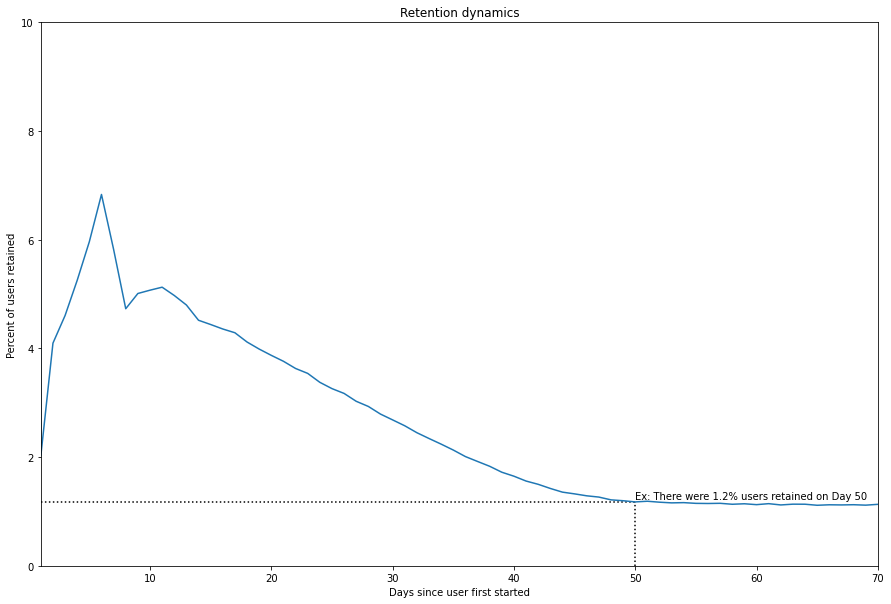

In [26]:
start_date2 = '2018-01-01'
finish_date2 = '2018-02-01'
dynamic_retention(df_reg, df_auth, start_date2, finish_date2)

###### Дополнительные графики и таблицы для выдачи некоторых рекомендаций

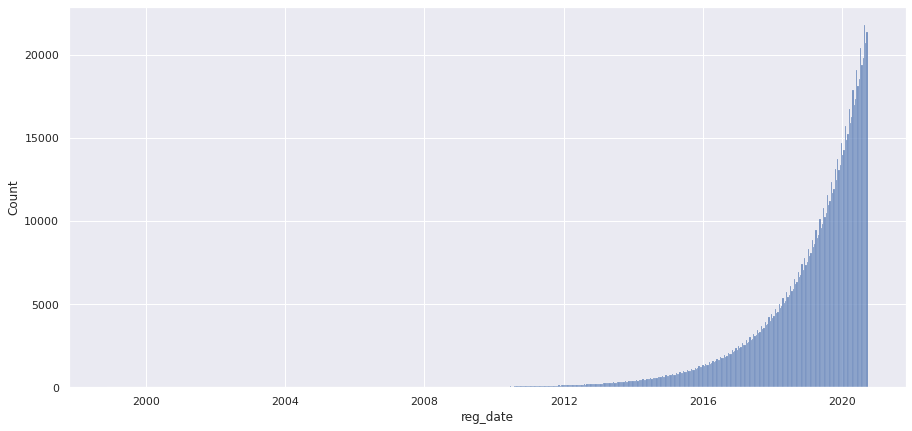

In [27]:
df_reg['reg_date'] = pd.to_datetime(df_reg.reg_ts, unit='s').dt.round('d')
sns.set(rc={'figure.figsize':(15, 7)})
sns.histplot(df_reg.reg_date)

In [28]:

df_reg1 = df_reg
df_reg['reg_time'] = pd.to_datetime(df_reg.reg_ts, unit = 's')
df_reg1['reg_year'] = df_reg1['reg_time'].values.astype('datetime64[Y]')
df_reg1['reg_year'] = df_reg1['reg_year'].dt.year
reg_by_year = df_reg1.groupby('reg_year', as_index=False).agg({'uid':'nunique'})

In [29]:
# Таблица распределения зарегистрированных пользователей по годам
reg_by_year

,reg_year,uid
0,1998,1
1,1999,1
2,2000,4
3,2001,6
4,2002,10
5,2003,20
6,2004,35
7,2005,65
8,2006,119
9,2007,216


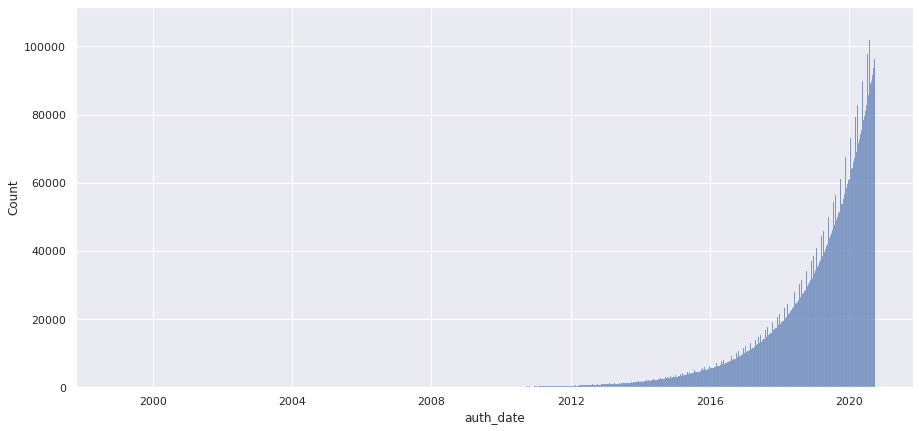

In [30]:
df_auth['auth_date'] = pd.to_datetime(df_auth.auth_ts, unit='s').dt.round('d')
sns.set(rc={'figure.figsize':(15, 7)})
sns.histplot(df_auth.auth_date)

###### Выводы
Из дополнительных данных можно предположить, что первые несколько лет приложение скорее всего тестировалось командой разработчиков/тестировщиков. И для корректого вычисления вычисления retention стоит использовать более поздние приоды работы приложения.
Судя по выбросам даннх в графиках авторизации и регистрации, скорее всего происходят некоторые события, которые подогревают интерес пользователей, а так же позволяющие добиться притока новых юзеров. По этой же причине скорее всего мы видим некоторый всплеск retenrion на тепловой карте на 6й день. 

### Задание 2
Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [31]:
# импорт данных
public_key = 'https://disk.yandex.ru/d/12gk_ATEeBZm4A'
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url) 
download_url = response.json()['href']
download_response = requests.get(download_url)
ab_test = pd.read_csv(download_url, sep=';')

In [32]:
# предобработка данных
ab_test.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [33]:
# количество строк
ab_test.shape[0]

404770

In [34]:
# проверка типов данных
ab_test.dtypes

user_id       int64
revenue       int64
testgroup    object
dtype: object

In [35]:
# проверка наличия пропущенных значений
ab_test.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

In [36]:
# проверка количества человек в каждой из тестовых групп на соответствие
ab_test.query('revenue > 0').groupby('testgroup').agg({'user_id':'nunique'})

,user_id
testgroup,
a,1928
b,1805


Проведение вычисления ARPU, ARPPU & CR метрик

In [37]:
ARPU = ab_test.groupby('testgroup').revenue.mean().round(2)
ARPU

testgroup
a    25.41
b    26.75
Name: revenue, dtype: float64

In [38]:
ARPPU = ab_test.query('revenue > 0').groupby('testgroup').revenue.mean().round(2)
ARPPU

testgroup
a    2664.00
b    3003.66
Name: revenue, dtype: float64

In [39]:
CR = (ab_test.query('revenue > 0').groupby('testgroup').agg({'user_id':'nunique'})
      /ab_test.groupby('testgroup').agg({'user_id':'nunique'})*100).round(2)
CR

,user_id
testgroup,
a,0.95
b,0.89


In [40]:
# Вычисление на сколько в процентном отношении метрики отличаются между группами
ARPU_a = ab_test.query("testgroup == 'a'").revenue.mean()
ARPU_b = ab_test.query("testgroup == 'b'").revenue.mean()
ARPPU_a = ab_test.query("revenue > 0 and testgroup == 'a'").revenue.mean()
ARPPU_b = ab_test.query("revenue > 0 and testgroup == 'b'").revenue.mean()
delta_ARPU = ((ARPU_a - ARPU_b)/ARPU_b*100).round(2)
delta_ARPPU = ((ARPPU_a - ARPPU_b)/ARPPU_b*100).round(2)
CR_a = ab_test.query("testgroup == 'a' and revenue > 0").user_id.nunique()/ab_test.query("testgroup == 'a'").user_id.nunique()
CR_b = ab_test.query("testgroup == 'b' and revenue > 0").user_id.nunique()/ab_test.query("testgroup == 'b'").user_id.nunique()
delta_CR = round((CR_a - CR_b)/CR_b*100, 2) 

In [41]:
delta_ARPU
# a - контрольная группа
# b - тестовая группа

-5.0

In [42]:
delta_ARPPU

-11.31

In [43]:
delta_CR

7.11

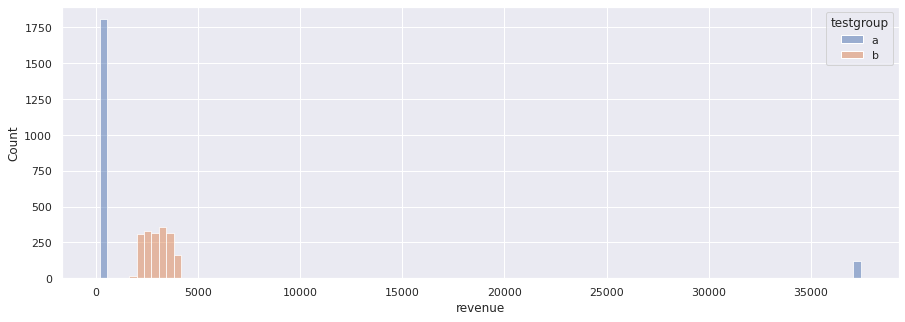

In [44]:
# С помощью гистограммы оценим распределение количества клиентов 
# (т.е. пользователей, которые провели оплату) в зависимости от группы
plt.figure(figsize=(15, 5))
sns.histplot(x = 'revenue', data = ab_test.query('revenue > 0'), hue = 'testgroup');

Примечательным является то, что контрольная группа не является монолитной, а состоит из двух подгрупп. Попробуем оценить являются ли группа клиентов платящих большие суммы выбросом.

In [45]:
#Расчёт количества клиентов контрольной группы в совершающих небольшие транзакции, 
# а также общей суммы полученной с таких клиентов.
display (ab_test.query('testgroup == "a" and revenue < 35000 and revenue > 0').user_id.nunique(), 
ab_test.query('revenue < 1000 and revenue > 0').revenue.sum())

1805

545937

In [46]:
# Расчёт количества клиентов контрольной группы совершающих крупные транзакции, 
# а также общей суммы полученной с таких клиентов.
display (ab_test.query('revenue > 35000').user_id.nunique(),
ab_test.query('revenue > 35000').revenue.sum())

123

4590252

In [47]:
# Расчёт процентного соотношения подгрупп контрольной группы
display ((ab_test.query('revenue < 1000 and revenue > 0').revenue.sum()/ab_test.query("testgroup == 'a'").revenue.sum()*100).round(2),
         (100 - ab_test.query('revenue < 1000 and revenue > 0').revenue.sum()/ab_test.query("testgroup == 'a'").revenue.sum()*100).round(2))

10.63

89.37

In [48]:
# Процент клиентов совершающих крупные суммы транзакций относительно общего количества клиентов контрольной группы.
round((ab_test.query('testgroup == "a" and revenue > 35000').user_id.nunique()
       /ab_test.query('testgroup == "a" and revenue > 0').user_id.nunique()*100),2)

6.38

Мы имеем дело с прибылью, по-этому нельзя игнорировать массив клиентов, котрые делают 90% прибыли. Исходя из произведённых расчётов сделаем предположение, что акционная модель контрольной группы нацелена как раз на пользователей, которые совершают крупные суммы транзакций (свыше 35000), а прибыль с остальных пользователей является сопутствующей.

Перейдём к проверке статистической значимости полученных результатов.

In [49]:
# предварительно для упрощения разобъём общий датафрейм на два: данные контрольной группы и данные тестовой группы по всем юзерам
df_a = ab_test.query("testgroup == 'a'")
df_b = ab_test.query("testgroup == 'b'")
# предварительно для упрощения разобъём общий датафрейм на два: данные контрольной группы и данные тестовой группы по клиентам
df_a_rev = ab_test.query("testgroup == 'a' and revenue > 0")
df_b_rev = ab_test.query("testgroup == 'b' and revenue > 0")

In [50]:
# Для начала используем тест Шапиро-Вилка для проверки нормальности распределения в группах
# Нулевая гипотеза (H0): распределение значений revenue в группе нормальное
# Альтернативная гипотеза (H1): распределений значений revenue в групе не нормальное

In [51]:
# Контрольная группа
stat, p = ss.shapiro(df_a_rev['revenue'])
print('Statistics=%.3f, p-value=%.3f' % (stat, p))

Statistics=0.267, p-value=0.000


In [52]:
# Тестовая группа
stat, p = ss.shapiro(df_b_rev['revenue'])
print('Statistics=%.3f, p-value=%.3f' % (stat, p))

Statistics=0.958, p-value=0.000


###### Вывод: 
отклоняем нулевую гипотезу о нормальности распределений каждой из групп

Несмотря на то, что мы отклонили гипотезу о нормальности распределения значений в тестовой и контрольной группе, проверим возможность использования T-критерия Стьюдента. Данные выборок по акционным предложениям довольно большие. Необходимо проверить требование гомогенности дисперсий внутри наших групп - они должны быть примерно равны. Это мы можем проверить с помощью критерия Левена

In [53]:
# критерий Левена
# Нулевая гипотеза (H0): Дисперсии внутри тестовой и контрольной группы примерно равны (p-value > 0.05)
# Альтернативная гипотеза (H1): Дисперсии внутри тестовой и контрольной группы различаются (p-value < 0.05)
ss.levene(df_a.revenue,df_b.revenue)

LeveneResult(statistic=0.3896289474701388, pvalue=0.5324948591043842)

###### Вывод:
отколнить нулевую гипотезу нельзя. Требование гомогенности дисперсий соблюдается.
Возможно использование Т-критерия Стьюдента.

### ARPU
По условию задачи известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. Проверим является ли эта разница статистически значимой с помощью методов t-test, Манна-Уитни и Bootstrap

###### Гипотезы
* Н0 - разница в значениях revenue между тестовой и контрольной отсутствует (если р-уровень значимости больше 0.05)
* Н1 - разница в значениях revenue существует (р-уровень значимости меньше 0.05)

In [54]:
# t-test
ss.ttest_ind(df_a.revenue,df_b.revenue)

Ttest_indResult(statistic=-0.6242026493616787, pvalue=0.532494858971837)

Отклоняем альтернативную гипотезу

In [55]:
# непараметрический критерий Манна-Уитни
ss.mannwhitneyu(df_a.revenue, df_b.revenue)

MannwhitneyuResult(statistic=20491259376.0, pvalue=0.06269701316074398)

Отклоняем альтернативную гипотезу

###### Гипотезы
* Н0 - разница в средних значениях ARPU в обоих группах отсутствует, если р-уровень значимости больше 0.05
* Н1 - разница существует, если р-уровень значимости меньше 0.05

In [56]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.figure(figsize=(10,6))
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
            bar.set_edgecolor('black')
        else: 
            bar.set_facecolor('blue')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

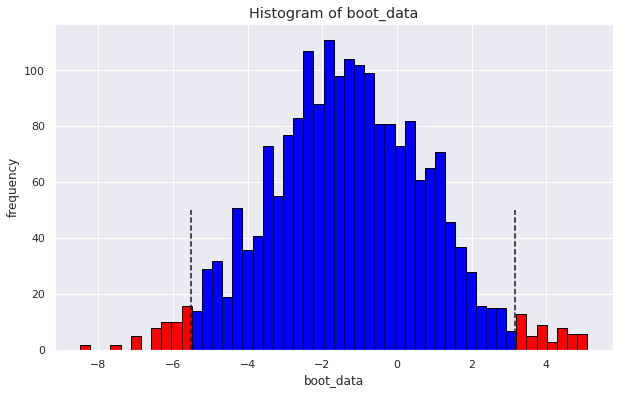

In [57]:
booted_data_mean = get_bootstrap(df_a.revenue, df_b.revenue, boot_it = 2000, \
                                 statistic = np.mean)

In [58]:
# p-value
booted_data_mean['p_value']

0.5465408744658964

###### Вывод:
На основаниии полученных данных (p > 0.05 и 0 лежит в границах доверительного интервала) мы не можем отклонить гипотезу о том, что разница в средних значениях в обоих группах отсутствует.

### ARPPU
Согласно нашим вычислениям разница между метрикой ARPPU в двух сравниваемых группах составляет 11,3%. Также сделаем проверку на статистически достоверную разницу. Гипотезы выдвигаем те же.

In [59]:
# t-test
ss.ttest_ind(df_a_rev.revenue,df_b_rev.revenue)

Ttest_indResult(statistic=-1.5917100176862002, pvalue=0.11153459157259504)

Отклоняем альтернативную гипотезу

In [60]:
# непараметрический критерий Манна-Уитни
ss.mannwhitneyu(df_a_rev.revenue, df_b_rev.revenue)

MannwhitneyuResult(statistic=222015.0, pvalue=0.0)

Принимаем альтернативную гипотезу

###### Гипотезы для Bootstrap
* Н0 - разница в средних значениях ARPPU в обоих группах отсутствует, если р-уровень значимости больше 0.05
* Н1 - разница существует, если р-уровень значимости меньше 0.05

In [61]:
def get_bootstrap1(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.figure(figsize=(10,6))
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
            bar.set_edgecolor('black')
        else: 
            bar.set_facecolor('blue')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

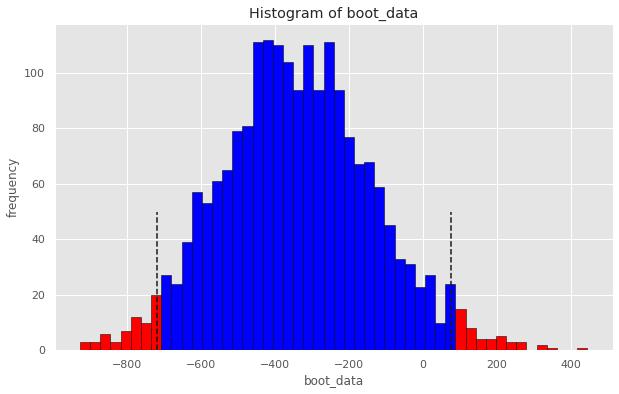

In [62]:
booted_data_mean1 = get_bootstrap1(df_a_rev.revenue, df_b_rev.revenue, boot_it = 2000, \
                                 statistic = np.mean)

In [63]:
# p-value
booted_data_mean1['p_value']

0.09722125746433938

###### Вывод: 
На основаниии полученных данных (p > 0.05 и 0 лежит в границах доверительного интервала) мы не можем отклонить гипотезу о том, что разница в средних значениях в обоих группах отсутствует.

#### Общие выводы
Результаты данного A/B теста показали, что относительно метрики ARPU статистически значимых различий нет. Метрика ARPPU оказалась противоречивой и в некоторой степени пограничной. Основной проблемой контрольного набора акционных предложений видится большая зависимость от клиентов переводящих крупные суммы транзакций, потеря каждого такого клиента будет нести весомый вклад в метрику ARPPU. Для тестовой группы присуще равномерное распределение, а следовательно поведение пользователей будет более предсказуемым. 

Предварительно я бы остановился на тестовом наборе акционных предложений. Но предложил бы провести дополнительные стресс-тесты направленные на изучение степени оттока/притока клиентов, что потенциально позволило бы доказать более сильное влияние созданных условий на контрольную группу.

### Задание 3
В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

###### Оценить результаты последнего прошедшего события возможно с помощью следующих метрик:

1. DAU. Динамика DAU позволит изучить как падает интерес к событию с течением времени, а так же сравнить показатели DAU во время ивента и в обычные дни.
2. MAU. Позволит в некоторой степени оценить интерес к ивенту текущего месяца.
3. avgDAU/MAU. Относительная метрика позволяющая оценить активность во время ивента вне зависимости от времени года.
4. ASL. Среднее время сессии за период позволит сравнить показатель во время периода тематического события с периодом без ивента, а так же с аналогичными периодами в других месяцах.
5. Набор экономических метрик ARPU, ARPPU & CR
6. Retention rate & churn rate. Для оценки уровня удержания и оттока когорт пользователей. Основной упор на сравнение  когорт, во временных рамках ивента с когортами образовавшимися в остальное время.
7. CSAT. Оценка качества текущего ивента по сравниению с прошедшими ранее.

Для усложненной механики дополняем:
1. Отказы. Отношение количества пользователей отказавшихся проходить уровни с наградой после неудачной попытки прохождения на n-ный раз к общему количеству попыток прохождения уровня.
2. Среднее количество повторных попыток когорт пользователей пройти уровни. Когорты сформировать по времени регистрации пользователя.